## 0.0 Imports

In [1]:
%pip install pandas
%pip install scikit-learn
%pip install openpyxl
%pip install --upgrade pip
%pip install matplotlib
%pip install seaborn
%pip install pycm==4.3

import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from pycm import ConfusionMatrix
import matplotlib.pyplot as plt
from collections import Counter

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1.0 Leitura do conjunto de dados

In [2]:
ds = pd.read_excel('GPS_Data_Simplified_2D_Feature_Map.xlsx',  dtype = str)
ds

,PRN,DO,PD,RX,TOW,CP,EC,LC,PC,PIP,PQP,TCD,CN0,Output
0,6,1160.67140780005,-238359.543281858,491568,491568.000795082,-24660.2632931903,163521.78,170008.81,179294.97,178420.33,-17688.178,1158.4806,49.412529,0
1,6,1157.82780811118,-238363.921192484,491568.02,491568.020795096,-24683.4685202421,158277.05,160253.09,182106.11,182106.05,158.33333,1160.7948,49.452686,0
2,6,1161.13593220979,-238368.638614547,491568.04,491568.040795112,-24706.6873571922,184442.36,193125.89,208228.02,-205198.3,35391.59,1157.6909,49.480145,0
3,6,1161.15661719479,-238373.391774656,491568.06,491568.060795128,-24729.9200394638,159812.45,169960.55,187550.72,187543,-1701.944,1161.1343,49.433769,0
4,6,1160.6908929619,-238378.127065742,491568.08,491568.080795144,-24753.1539994783,183557.66,191912.58,208403.5,208330.05,-5532.8999,1161.1759,49.39167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510525,4,-1113.336004,1949364.523,264109.58,264109.5735,114898.7034,90875.36719,104455.8516,99626.32031,-95613.48438,27990.45703,-1113.685547,43.05340958,0
510526,7,3542.882288,2823824.599,264109.58,264109.5706,-195707.189,139266.9219,133094.5938,144683.2656,-142087.5469,-27283.24023,3532.388916,46.4665451,0
510527,9,1205.18283,1298452.438,264109.58,264109.5757,-136011.0641,104211.4117,111445.296,125940.9297,-125705.6406,-9212.472557,2779.28833,47.58116531,3
510528,27,2814.03045,2298963.88,264109.58,264109.5723,-300750.7153,107693.0131,121277.7439,133731.1114,132020.7188,-21319.94265,2780.66748,46.21652603,3


### 1.1a Funções auxiliares

In [3]:
translated_names = {
    "TPR": "Probabilidade de detecção",
    "FPR": "Probabilidade de alarme falso",
    "PMD": "Probabilidade de detecção falsa",
    "TNR": "Especificidade",
    "ERR": "Taxa de Erro",
    "ACC": "Acurácia",
    "F1": "F1-Score",
    "MCC": "Coeficiente MCC",
    "PFA": "Probabilidade de alarme falso",
  }


# function that receive a confusion matrix and return weighted metrics
def get_weighted_metrics(cm, metrics_to_show=["TPR", "FPR", "TNR", "ERR", "ACC", "F1", "MCC"]):
    classes = cm.classes
    metrics = {}
    metrics_weighted = {}
    counts = Counter(cm.actual_vector)
    total = len(cm.actual_vector)

    for metric in metrics_to_show:
      metrics.update({metric: list(cm.class_stat[metric].values())})

    metrics.update({"PMD": [1 - cm.TPR[c] for c in classes]})
    weights = np.array([counts.get(cls, 0) / total for cls in classes])
    
    for metric in metrics_to_show:
      values_per_class = np.array(list(cm.class_stat[metric].values()))
      weighted_values = np.sum(values_per_class * weights)
      metrics_weighted[metric] = weighted_values
    
    values_per_class = np.array(metrics["PMD"])
    metrics_weighted["PMD"] = np.sum(values_per_class * weights)

    return metrics_weighted

def print_weighted_metrics(metrics_weighted):
    data = [(translated_names.get(k, k), v) for k, v in metrics_weighted.items()]

    df = pd.DataFrame(data, columns=["Métrica", "Valor"], index=None)
    df["Valor"] = df["Valor"].map(lambda x: f"{x:.4f}")
    
    return df


def plot_metrics_graphic(results, metrics_to_plot):
  algorithms = list(results.keys())
  first_metric_value = [results[alg][metrics_to_plot[0]] * 100 for alg in algorithms] 
  second_metric_value = [results[alg][metrics_to_plot[1]] * 100 for alg in algorithms] 

  x = np.arange(len(algorithms))
  width = 0.15
  gap = 0.05

  _, ax = plt.subplots()

  ax.bar(x - width/2 - gap/2, first_metric_value, width, label=translated_names.get(metrics_to_plot[0].upper(), metrics_to_plot[0].upper()), color='skyblue')
  ax.bar(x + width/2 + gap/2, second_metric_value, width, label=translated_names.get(metrics_to_plot[1].upper(), metrics_to_plot[1].upper()), color='lightgray')

  ax.set_ylabel('%', fontsize=12)
  ax.set_xticks(x)
  ax.set_xticklabels(algorithms, fontsize=10)
  ax.tick_params(axis='y', labelsize=10)
  ax.legend(
      loc='upper center',
      bbox_to_anchor=(0.5, -0.15),
      ncol=2,
      fontsize=9
  )

  ax.yaxis.grid(True, linestyle='--', alpha=0.6)
  plt.tight_layout()
  plt.show()


### 1.1 Pre-processamento dos dados
Utilização da técnica _Principal Component Analysis (PCA)_

> Esta técnica visa reduzir a dimensão do conjunto de dados.

In [3]:
# código PCA

### 1.1 Extração das features e da classe


In [4]:
feature_columns = ["PRN","DO","PD",	"RX","TOW","CP","EC","LC","PC",	"PIP","PQP","TCD","CN0"]
X = ds[feature_columns].values
y = ds['Output'].values

ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510530 entries, 0 to 510529
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PRN     510530 non-null  object
 1   DO      510530 non-null  object
 2   PD      510530 non-null  object
 3   RX      510530 non-null  object
 4   TOW     510530 non-null  object
 5   CP      510530 non-null  object
 6   EC      510530 non-null  object
 7   LC      510530 non-null  object
 8   PC      510530 non-null  object
 9   PIP     510530 non-null  object
 10  PQP     510530 non-null  object
 11  TCD     510530 non-null  object
 12  CN0     510530 non-null  object
 13  Output  510530 non-null  object
dtypes: object(14)
memory usage: 54.5+ MB


### 1.2 Pre-processamento dos dados
Utilização da técnica _Principal Component Analysis (PCA)_

> Esta técnica visa reduzir a dimensão do conjunto de dados.

In [4]:
# código PCA
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

### 1.3 Separação dos dados de treinamento e teste
> Separação foi de 70% do conjunto de dados para treino e 30% para testes


In [6]:
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



## 2. Treino e teste do K-NN

In [7]:
cl_sklearn = KNeighborsClassifier(n_neighbors=3)
cl_sklearn.fit(X_train, y_train)
y_pred = cl_sklearn.predict(X_test)

### 2.1 Métricas de desempenho do K-NN

In [ ]:
cm = ConfusionMatrix(actual_vector=y_test,predict_vector=y_pred)

weighted_metrics_knn = get_weighted_metrics(cm)
print_weighted_metrics(weighted_metrics_knn)


,Métrica,Valor
0,Probabilidade de detecção,0.8962
1,Probabilidade de alarme falso,0.1541
2,Especificidade,0.8459
3,Taxa de Erro,0.0737
4,Acurácia,0.9263
5,F1-Score,0.8959
6,Coeficiente MCC,0.7459
7,Probabilidade de detecção falsa,0.1038


### 2.2 Matriz de confusão

<Axes: title={'center': 'Matriz de Confusão'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

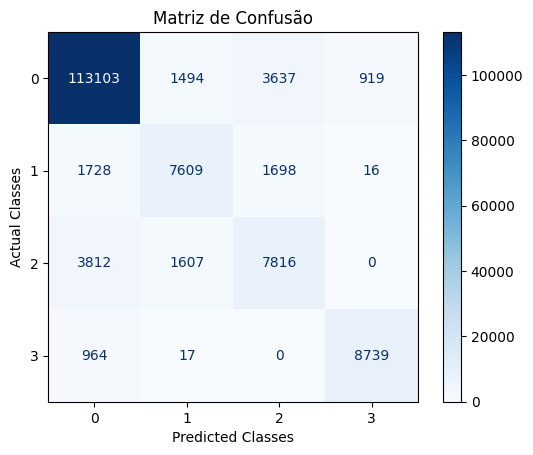

In [ ]:
cm.plot(number_label=True, title="Matriz de Confusão", cmap=plt.cm.Blues) # type: ignore

## 3. Treino e teste do Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

### 3.1 Métricas de desempenho do Random Forest

In [ ]:
cm_rf = ConfusionMatrix(actual_vector=y_test,predict_vector=y_pred)

weighted_metrics_rf = get_weighted_metrics(cm_rf)
print_weighted_metrics(weighted_metrics_rf)

,Métrica,Valor
0,Probabilidade de detecção,0.9044
1,Probabilidade de alarme falso,0.1454
2,Especificidade,0.8546
3,Taxa de Erro,0.0701
4,Acurácia,0.9299
5,F1-Score,0.9042
6,Coeficiente MCC,0.7612
7,Probabilidade de detecção falsa,0.0956


### 3.2 Matriz de confusão

<Axes: title={'center': 'Matriz de Confusão'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

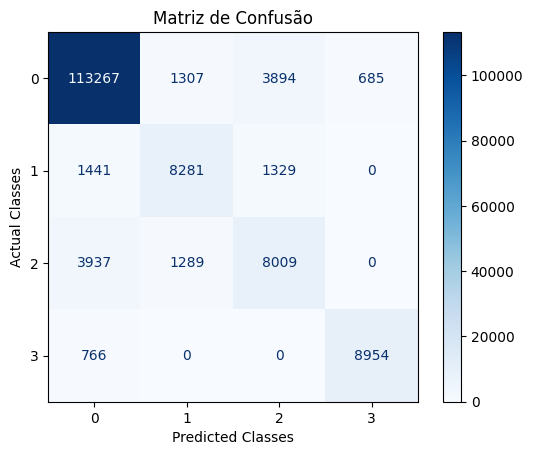

In [12]:
cm_rf.plot(number_label=True, title="Matriz de Confusão", cmap=plt.cm.Blues) # type: ignore

## 4. Probabilidade de detecção e acurácia

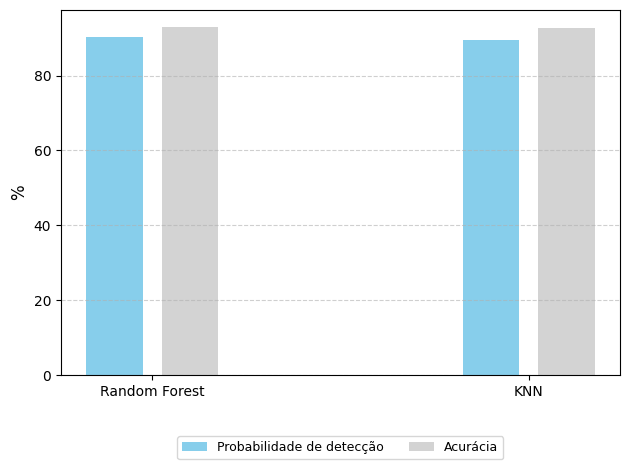

In [13]:
results = {
    "Random Forest": {"tpr": weighted_metrics_rf['TPR'], "acc": weighted_metrics_rf['ACC'], "pmd": weighted_metrics_rf['PMD'], "pfa": weighted_metrics_rf['FPR']},
    "KNN": {"tpr": weighted_metrics_knn['TPR'], "acc": weighted_metrics_knn['ACC'], "pmd": weighted_metrics_knn['PMD'], "pfa": weighted_metrics_knn['FPR']},
}

plot_metrics_graphic(results, metrics_to_plot=["tpr", "acc"])

## 5. Probabilidade de detecções incorretas e alarmes falsos

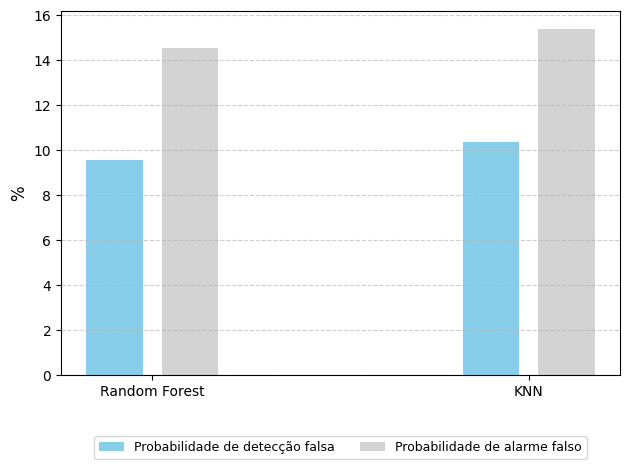

In [14]:
plot_metrics_graphic(results, metrics_to_plot=["pmd", "pfa"])

## 4. Treino e teste do Gausian Naive Bayes

In [12]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

### 4.1 Métricas de desempenho do Gausian Naive Bayes Forest

In [13]:
accuracy_rf = accuracy_score(y_test, y_pred)
cm_rf = confusion_matrix(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred, average='weighted')
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy of Gausian Naive Bayes: {accuracy_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"Precision Score: {precision_rf:.4f}")
print(f"Recall Score: {recall_rf:.4f}")
print(f"Error: {1 - accuracy_rf:.4f}")

/home/jessicafileto/Documents/workspace/ufabc/ccm-102/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy of Gausian Naive Bayes: 0.7252
F1 Score: 0.6799
Precision Score: 0.6416
Recall Score: 0.7252
Error: 0.2748


### 4.2 Matriz de confusão

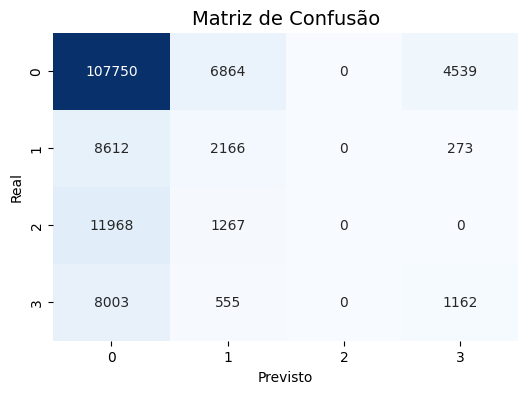

In [14]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title("Matriz de Confusão", fontsize=14)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()